# The Wilson-Cowan model

The Wilson–Cowan model considers a homogeneous population of interconnected neurons of excitatory and inhibitory subtypes. All cells receive the same number of excitatory and inhibitory afferents, that is, all cells receive the same average excitation, $x(t)$. The target is to analyze the evolution in time of number of excitatory and inhibitory cells firing at time $t$,
$E(t)$ and $I(t)$ respectively.


In [1]:
import brainstate
import braintools
import brainmass

import matplotlib.pyplot as plt
import numpy as np

from datasets import Dataset

plt.rcParams['image.cmap'] = 'plasma'

In [2]:
brainstate.environ.set(dt=0.1)

## Single node simulation

In [3]:
node = brainmass.WilsonCowanModel(
    1,
    noise_E=brainmass.OUProcess(1, sigma=0.01),
    noise_I=brainmass.OUProcess(1, sigma=0.01),
)
brainstate.nn.init_all_states(node)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return node.update()


indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

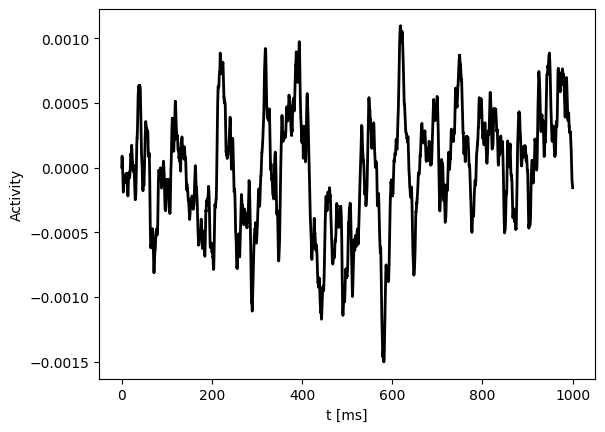

In [4]:
plt.plot(indices * brainstate.environ.get_dt(), exec_activity, c='k', lw=2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")
plt.show()

## Bifurcation diagram

Let's draw a simple one-dimensional bifurcation diagram of this model to orient ourselves in the parameter space.


In [5]:
# these are the different input values that we want to scan
exc_inputs = np.arange(0, 5.5, 0.05)

In [6]:
nodes = brainmass.WilsonCowanModel(
    exc_inputs.size,
    noise_E=brainmass.OUProcess(exc_inputs.size, sigma=0.01),
    noise_I=brainmass.OUProcess(exc_inputs.size, sigma=0.01),
)
brainstate.nn.init_all_states(nodes)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return nodes.update(exc_inputs)


indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

In [7]:
max_exc = exec_activity.max(axis=0)
min_exc = exec_activity.min(axis=0)

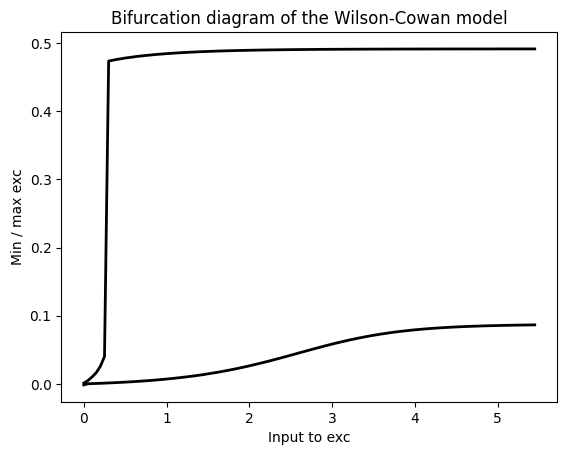

In [8]:
plt.plot(exc_inputs, max_exc, c='k', lw=2)
plt.plot(exc_inputs, min_exc, c='k', lw=2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")
plt.show()

## Brain network

In [9]:
hcp = Dataset('hcp')

Loading dataset hcp from D:\codes\projects\brainmass\examples\datasets\hcp.
Dataset hcp loaded.


In [13]:

class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2., k=1.):
        super().__init__()

        conn_weight = hcp.Cmat
        np.fill_diagonal(conn_weight, 0)
        delay_time = hcp.Dmat / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.tile(np.arange(conn_weight.shape[1]), conn_weight.shape[0])

        self.node = brainmass.WilsonCowanModel(
            80,
            noise_E=brainmass.OUProcess(80, sigma=0.01),
            noise_I=brainmass.OUProcess(80, sigma=0.01),
        )
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delay_time.flatten(), indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn_weight,
            k=k
        )

    def update(self):
        current = self.coupling()
        rE = self.node(current)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

In [14]:
net = Network()
brainstate.nn.init_all_states(net)
indices = np.arange(0, 6e3 // brainstate.environ.get_dt())
exes = brainstate.transform.for_loop(net.step_run, indices)

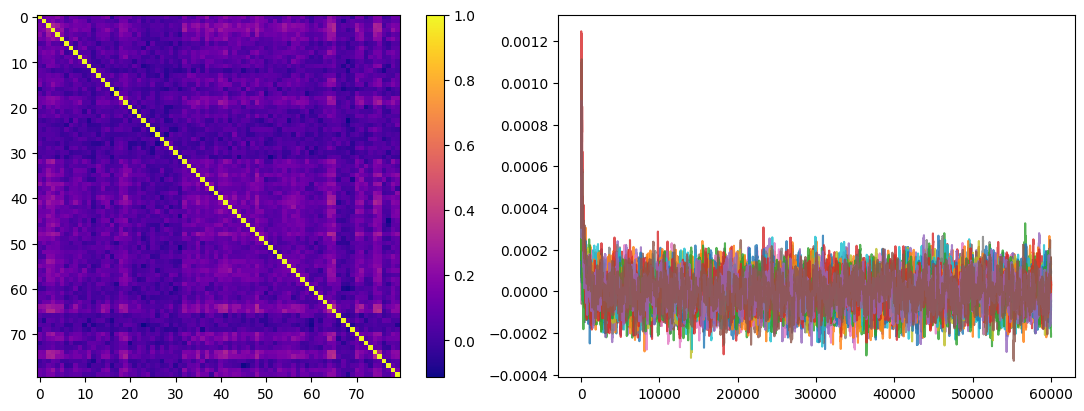

In [ ]:
fig, gs = braintools.visualize.get_figure(1, 2, 4, 6)
ax1 = fig.add_subplot(gs[0, 0])
fc = braintools.metric.functional_connectivity(exes)
ax = ax1.imshow(fc)
plt.colorbar(ax, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(indices, exes[:, ::5], alpha=0.8)
plt.show()